In [118]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
import math

In [119]:
class OutputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "wb")
        return self
       
    def write(self, value, length):
        assert isinstance(value, int), "value must be integer"
        assert isinstance(length, int), "length must be integer"
        assert value >= 0, "value must be non negative"
        assert value < 2 ** length, "value must be smaller than 2 ** length"
       
        self.word <<= length
        self.word |= value
        self.word_bits += length
   
        if self.word_bits >= 64:
            remaining = self.word_bits - 64
            self.file.write((self.word >> remaining).to_bytes(8, byteorder="big", signed=False))
            self.word &= (1 << remaining) - 1
            self.word_bits = remaining
   
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.word_bits != 0:
            self.write(0, 64 - self.word_bits)
           
        self.file.close()

In [120]:
class InputBitstream:
    def __init__(self, filename):
        self.filename = filename
       
    def __enter__(self):
        self.word = 0
        self.word_bits = 0
        self.file = open(self.filename, "rb")
        return self
       
    def read(self, length):
        assert length < 8 * 32, "length is too large"
       
        if length > self.word_bits:
            value = self.file.read(32)
            self.word <<= len(value) * 8
            self.word_bits += len(value) * 8
            self.word |= int.from_bytes(value, byteorder="big", signed=False)
           
        if length > self.word_bits:
            raise "Unexpected end of file"
               
        result = self.word >> (self.word_bits - length)
        self.word_bits -= length
        self.word &= (1 << self.word_bits) - 1
       
        return result
   
    def __exit__(self, exc_type, exc_val, exc_tb):    
        self.file.close()

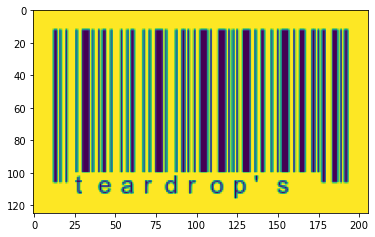

In [121]:
img = imageio.imread("barcodes/sample-000001.png")
plt.imshow(img) #im

primeraLinea = 0
segonaLinea = 0
ultimaRepetida = 0
margeInferior = 0

for fila in range(img.shape[0]):
    for columna in range(img.shape[1]):
        if img[fila][columna] != 255:
            if primeraLinea == 0:
                primeraLinea = fila
                segonaLinea = fila+1


segonaLinea = img[segonaLinea]

for x in range(primeraLinea+1, img.shape[0]):
    
    if False in (img[x] == segonaLinea):
        if ultimaRepetida == 0:
            ultimaRepetida = x


for i in range(img.shape[0]):
    if img[i][12] != 255:
        margeInferior = i


            
#Left Margin
leftMargin = 0
           
for i in range(len(img[ultimaRepetida])):
    if img[ultimaRepetida-1][i] != img[ultimaRepetida][i]:
        if leftMargin ==0:
            leftMargin = i

            
            
#Right Margin
rightMargin = 0
anterior = 0

#for i in reversed(range(len(img[ultimaRepetida]))):
for i in reversed(range(img.shape[1])):
    if img[ultimaRepetida-1][i] != img[ultimaRepetida][i]:
        if rightMargin ==0:
            rightMargin = anterior
    anterior = i
            
            
#print(margeInferior)
#print(leftMargin)
#print(rightMargin)
#print('---------')
#print(primeraLinea)
#print(segonaLinea)
#print("La fila es repeteix fins la fila", ultimaRepetida)


In [122]:
#Fins ara tenim una funcio que retorna la ultima fila que es repeteix dins del barcode
# codeBook = primeraLinia + SegonaLinia + totes les linies que no es repeteixen
# a cada linia li podem dir codeword
# per ara hardcodegem les mesures, ja les enviarem

#codeBook =[]
#codeBook.append(img[primeraLinea])
#codeBook.append(segonaLinea)

#wordImage = []

#for i in range(ultimaRepetida, img.shape[0]):
#    for value in img[i]:   
#        wordImage.append(value)
#    codeBook.append(img[i])
#wordImageNP = np.array(wordImage)
#wordImageNP.resize(img.shape[1],img.shape[0]-ultimaRepetida)

#print("Generat Codebook")


In [123]:
def getMSE(img1, img2):  # MSE of 2 images
    return (np.sum(np.square(img1 - img2))) / img1.size


In [124]:
#Obtenir la primera a partir de la segona --> mitja del valor i color blanc(255)

def getFirstLine(common):
    computedPrimera = []

    for el in common:
        newVal = (el+255)//2
        if newVal> (el+(255//2)+0.5):
            newVal+=1
        computedPrimera.append(newVal)
    
    return computedPrimera




In [125]:
shape_x = img.shape[1]
shape_y = img.shape[0]

print(shape_x, shape_y)

test1 = np.asarray(img[13]) #common row
test1 = test1.tolist()


#remove first and last 12 255
test = test1[12:-12]

#print(test)


#write
with open('test222.bin', "wb+") as f:
    
    #header
    f.write(shape_y.to_bytes(2, byteorder="big", signed=False))
    f.write(shape_x.to_bytes(2, byteorder="big", signed=False))
    
    
    for i in range(len(test)):
        f.write(test[i].to_bytes(2, byteorder="big", signed=False))
    
    for i in range(12, leftMargin):
        f.write(int(img[margeInferior][i]).to_bytes(2, byteorder="big", signed=False))
    
    for i in range(rightMargin, shape_x):
        f.write(int(img[margeInferior][i]).to_bytes(2, byteorder="big", signed=False))
            
            
#read 
commonLine =[]

with open('test222.bin', "rb") as f:
    testReconstructed = []
    read = f.read()
    i=0
    cont=0
    ultimaRepetida = 100
    
    #header
    reconstructed_y = int.from_bytes(read[:2], byteorder="big")
    reconstructed_x = int.from_bytes(read[2:4], byteorder="big")
    
    
    ultimaLinea = [255 for i in range(reconstructed_x)]
    
        
    read = read[4:]
    
    
    for j in range(len(test)):
    
        commonLine.append(int.from_bytes(read[i:i+2], byteorder="big"))
        i+=2
    
    
    #ultima linea
    for j in range(12, leftMargin):
        ultimaLinea[j] = int.from_bytes(read[i:i+2], byteorder="big")
        i+=2
        
    
    for j in range(rightMargin, shape_x):
        ultimaLinea[j] = int.from_bytes(read[i:i+2], byteorder="big")
        i+=2


#reconstruir

#12 first 255
finalReconstructed = [255 for x in range(12)]

#12 last 255
for i in range(12):
    commonLine.append(255)

    
finalReconstructed += commonLine


#print(finalReconstructed)

primera = getFirstLine(finalReconstructed)
#ultima = getLastLine(finalReconstructed)
ultima = ultimaLinea

img_reconstructed = np.array([[255 for x in range(shape_x)] for j in range(shape_y)])

#asignem la primera fila
img_reconstructed[12] = primera
img_reconstructed[13:ultimaRepetida] = finalReconstructed



#laterals:

#LEFT
for i in range(ultimaRepetida, margeInferior):
    for j in range(leftMargin):
        img_reconstructed[i][j] = finalReconstructed[j]

#RIGHT
for i in range(ultimaRepetida, margeInferior):
    for j in reversed(range(rightMargin, reconstructed_x)):
        img_reconstructed[i][j] = finalReconstructed[j]

        
#Last Line
for j in range(12, leftMargin):
    img_reconstructed[margeInferior][j] = ultimaLinea[j]

for j in reversed(range(rightMargin, reconstructed_x-12)):
    img_reconstructed[margeInferior][j] = ultimaLinea[j]



206 125


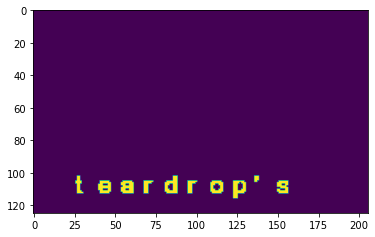

In [126]:
right = np.array([[255 for x in range(shape_x)] for j in range(shape_y)])

for i in range(shape_y):
    for j in range(shape_x):
        if img[i][j] == img_reconstructed[i][j]:
            right[i][j] = 0
        
            
        
plt.imshow(np.asarray(right))        

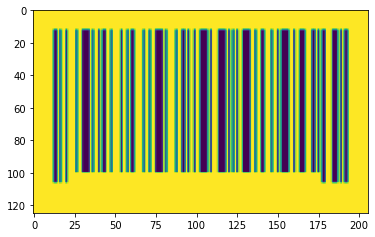

In [127]:
plt.imshow(np.asarray(img_reconstructed))

In [128]:
def rel_freq(x):
    freqs = [(value, x.count(value) / len(x)) for value in set(x)] 
    return sorted(freqs,key=lambda x:x[::-1],reverse=True)

In [129]:
print(shape_y)

125


In [130]:
print((531*8)/(shape_x*shape_y)) #calcul dels bps actuals

0.16497087378640776


In [131]:
#Codi Huffman Encoding
from collections import Counter
from itertools import chain

def count_symbols(pixels):
    values = chain.from_iterable(pixels)
    counts = Counter(values).items()
    return sorted(counts, key=lambda x:x[::-1])

def build_tree(counts) :
    nodes = [entry[::-1] for entry in counts] # Reverse each (symbol,count) tuple
    while len(nodes) > 1 :
        leastTwo = tuple(nodes[0:2]) # get the 2 to combine
        theRest = nodes[2:] # all the others
        combFreq = leastTwo[0][0] + leastTwo[1][0]  # the branch points freq
        nodes = theRest + [(combFreq, leastTwo)] # add branch point to the end
        print(nodes)
        #nodes.sort() # sort it into place
        sorted(nodes, key=lambda x:x[0])
    return nodes[0] # Return the single tree inside the list
def trim_tree(tree) :
    p = tree[1] # Ignore freq count in [0]
    if type(p) is tuple: # Node, trim left then right and recombine
        return (trim_tree(p[0]), trim_tree(p[1]))
    return p # Leaf, just return it
def assign_codes_impl(codes, node, pat):
    if type(node) == tuple:
        assign_codes_impl(codes, node[0], pat + [0]) # Branch point. Do the left branch
        assign_codes_impl(codes, node[1], pat + [1]) # then do the right branch.
    else:
        codes[node] = pat # A leaf. set its code

def assign_codes(tree):
    codes = {}
    assign_codes_impl(codes, tree, [])
    return codes
def to_binary_list(n):
    """Convert integer into a list of bits"""
    return [n] if (n <= 1) else to_binary_list(n >> 1) + [n & 1]

def from_binary_list(bits):
    """Convert list of bits into an integer"""
    result = 0
    for bit in bits:
        result = (result << 1) | bit
    return result

def pad_bits(bits, n):
    """Prefix list of bits with enough zeros to reach n digits"""
    assert(n >= len(bits))
    return ([0] * (n - len(bits)) + bits)
from PIL import Image

def compressed_size(counts, codes):
    header_size = 2 * 16 # height and width as 16 bit values

    tree_size = len(counts) * (1 + 8) # Leafs: 1 bit flag, 8 bit symbol each
    tree_size += len(counts) - 1 # Nodes: 1 bit flag each
    if tree_size % 8 > 0: # Padding to next full byte
        tree_size += 8 - (tree_size % 8)

    # Sum for each symbol of count * code length
    pixels_size = sum([count * len(codes[symbol]) for symbol, count in counts])
    if pixels_size % 8 > 0: # Padding to next full byte
        pixels_size += 8 - (pixels_size % 8)

    return (header_size + tree_size + pixels_size) / 8

def encode_header(image, bitstream):
    """
    height_bits = pad_bits(to_binary_list(image.height), 16)
    bitstream.write_bits(height_bits)    
    width_bits = pad_bits(to_binary_list(image.width), 16)
    bitstream.write_bits(width_bits)
    """
    height_bits = pad_bits(to_binary_list(image.shape[0]), 16)
    bitstream.write_bits(height_bits)    
    width_bits = pad_bits(to_binary_list(image.shape[1]), 16)
    bitstream.write_bits(width_bits)
    

def encode_tree(tree, bitstream):
    if type(tree) == tuple: # Note - write 0 and encode children
        bitstream.write_bit(0)
        encode_tree(tree[0], bitstream)
        encode_tree(tree[1], bitstream)
    else: # Leaf - write 1, followed by 8 bit symbol
        bitstream.write_bit(1)
        symbol_bits = pad_bits(to_binary_list(tree), 8)
        bitstream.write_bits(symbol_bits)

def encode_pixels(image, codes, bitstream):
    for pixel in image:
        for value in pixel:
            bitstream.write_bits(codes[value])

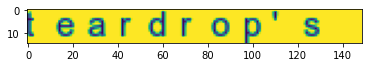

In [132]:
#Encoding process
#to start I need a np.array of the word to encode
wordBefore = np.array([[img[j][x] for x in range(leftMargin+1, rightMargin-1)] for j in range(ultimaRepetida+1, shape_y-9)])
plt.imshow(wordBefore)

In [133]:
counts = count_symbols(wordBefore)
print('Counts: %s' % counts)
tree = build_tree(counts)
print('Tree: %s' % str(tree))
trimmed_tree = trim_tree(tree)
print('Trimmed tree: %s' % str(trimmed_tree))
codes = assign_codes(trimmed_tree)
print('Codes: %s' % codes)

Counts: [(6, 1), (8, 1), (12, 1), (14, 1), (18, 1), (23, 1), (24, 1), (27, 1), (28, 1), (30, 1), (32, 1), (35, 1), (36, 1), (37, 1), (38, 1), (47, 1), (48, 1), (50, 1), (56, 1), (57, 1), (58, 1), (61, 1), (62, 1), (65, 1), (66, 1), (67, 1), (68, 1), (75, 1), (77, 1), (79, 1), (80, 1), (82, 1), (91, 1), (93, 1), (95, 1), (96, 1), (98, 1), (102, 1), (108, 1), (111, 1), (114, 1), (116, 1), (123, 1), (125, 1), (131, 1), (132, 1), (134, 1), (135, 1), (144, 1), (145, 1), (150, 1), (154, 1), (156, 1), (162, 1), (163, 1), (166, 1), (167, 1), (169, 1), (176, 1), (180, 1), (182, 1), (186, 1), (191, 1), (193, 1), (196, 1), (197, 1), (200, 1), (202, 1), (208, 1), (209, 1), (212, 1), (213, 1), (220, 1), (225, 1), (226, 1), (228, 1), (237, 1), (239, 1), (241, 1), (242, 1), (244, 1), (248, 1), (254, 1), (2, 2), (11, 2), (13, 2), (29, 2), (31, 2), (33, 2), (40, 2), (41, 2), (43, 2), (45, 2), (46, 2), (52, 2), (53, 2), (55, 2), (60, 2), (64, 2), (69, 2), (72, 2), (81, 2), (88, 2), (94, 2), (97, 2), (10

In [134]:
size_estimate = compressed_size(counts, codes)
print(size_estimate*8)
print(((531*8)+9536)/(shape_x*shape_y)) #calcul dels bps amb huffman

17536.0
0.5353009708737864


In [135]:
shape_x = img.shape[1]
shape_y = img.shape[0]

test1 = np.asarray(img[13]) #common row
test1 = test1.tolist()


#remove first and last 12 255
test = test1[12:-12]

#print(test)


#write
with open('testuki.bin', "wb+") as f:
    
    #header 1
    f.write(shape_y.to_bytes(3, byteorder="big", signed=False))
    f.write(shape_x.to_bytes(3, byteorder="big", signed=False))
    
    
    #Content 
    for i in range(len(test)):
        f.write(test[i].to_bytes(3, byteorder="big", signed=False))
    
    for i in range(12, leftMargin):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
    
    for i in range(rightMargin, shape_x):
        f.write(int(img[margeInferior][i]).to_bytes(3, byteorder="big", signed=False))
    
    #Encode Tree
    #not now
    #Encode Pixels
    for pixel in wordBefore:
        for value in pixel:
            #Como por cada code son 6-7 bits, de moment guardarem 7 bits per cada
            
            f.write(from_binary_list(codes[value]).to_bytes(1, byteorder="big", signed=False))


In [136]:
print()

In [137]:
print(from_binary_list(codes[20]))

43


In [205]:
print(wordBefore.shape)
print(15*92)

(2235,)
1380


In [139]:
def rle_encode(data):
    encoding = []
    prev_char = ''
    count = 1

    for el in data:
        if el != prev_char:

            if prev_char != '':
                encoding.append(count)
                encoding.append(prev_char)
                
            count = 1
            prev_char = el
        else:
            count += 1
    else:
        encoding.append(count)
        encoding.append(prev_char)
    return encoding


def rle_decode(data):
    reconstructed = []
    
    for i in range(len(data)):
        if i%2 == 0:
            for j in range(data[i]):
                reconstructed.append(data[i+1])
    
    
    return reconstructed

In [140]:
a = img[12]

print(len(rle_encode(a)))

print(rle_encode(a))

print(rle_decode(rle_encode(a)))

print(rle_decode(rle_encode(a)) == img[12])


262
[12, 255, 1, 203, 1, 127, 1, 139, 1, 255, 1, 171, 1, 203, 2, 255, 1, 139, 1, 235, 4, 255, 1, 171, 1, 203, 2, 255, 1, 139, 3, 127, 1, 139, 1, 255, 1, 171, 1, 203, 2, 255, 1, 139, 1, 235, 1, 203, 1, 127, 1, 139, 2, 255, 1, 203, 1, 171, 4, 255, 1, 235, 1, 139, 2, 255, 1, 203, 1, 171, 1, 255, 1, 139, 1, 127, 1, 203, 4, 255, 1, 203, 1, 171, 2, 255, 1, 171, 1, 203, 2, 255, 1, 139, 3, 127, 1, 139, 1, 255, 1, 171, 1, 203, 4, 255, 1, 203, 1, 171, 2, 255, 1, 171, 1, 127, 1, 171, 1, 255, 1, 139, 1, 235, 1, 255, 1, 235, 1, 139, 2, 255, 1, 203, 4, 127, 1, 203, 1, 235, 1, 139, 3, 255, 1, 235, 4, 127, 1, 171, 1, 255, 1, 139, 1, 235, 1, 203, 1, 171, 1, 255, 1, 139, 1, 235, 1, 255, 1, 235, 4, 127, 1, 171, 2, 255, 1, 171, 1, 203, 2, 255, 1, 139, 1, 127, 1, 203, 3, 255, 1, 171, 1, 203, 2, 255, 1, 139, 1, 235, 1, 203, 4, 127, 1, 203, 2, 255, 1, 139, 1, 235, 1, 255, 1, 235, 3, 127, 1, 203, 3, 255, 1, 171, 1, 127, 1, 171, 1, 255, 1, 139, 1, 235, 1, 203, 1, 127, 1, 139, 3, 255, 1, 235, 3, 127, 1, 203, 1,

In [141]:
#print(wordBefore)

#print(len(wordBefore[1]))
a = wordBefore.resize(len(wordBefore) * len(wordBefore[1]))





total = (rle_encode(wordBefore))

print(len(total))

print(total)


print(len(total)*8)

1030
[149, 255, 1, 222, 1, 176, 57, 255, 1, 243, 1, 0, 1, 187, 47, 255, 1, 167, 1, 0, 1, 215, 37, 255, 1, 60, 1, 115, 57, 255, 1, 243, 1, 0, 1, 187, 47, 255, 1, 168, 1, 0, 1, 216, 37, 255, 1, 59, 1, 115, 57, 255, 1, 243, 1, 0, 1, 187, 47, 255, 1, 197, 1, 1, 1, 244, 37, 255, 2, 0, 1, 31, 11, 255, 1, 242, 1, 103, 1, 20, 1, 15, 1, 69, 1, 210, 8, 255, 1, 216, 1, 81, 1, 17, 1, 5, 1, 36, 1, 154, 7, 255, 1, 247, 1, 0, 1, 140, 1, 25, 1, 33, 1, 240, 8, 255, 1, 228, 1, 77, 1, 12, 1, 30, 1, 162, 1, 0, 1, 187, 6, 255, 1, 247, 1, 0, 1, 140, 1, 25, 1, 33, 1, 240, 9, 255, 1, 236, 1, 103, 1, 26, 1, 8, 1, 64, 1, 202, 7, 255, 1, 251, 1, 0, 1, 132, 1, 49, 1, 29, 1, 53, 1, 195, 6, 255, 1, 241, 1, 72, 13, 255, 1, 168, 1, 43, 1, 7, 1, 28, 1, 119, 1, 251, 19, 255, 1, 58, 1, 112, 1, 248, 11, 255, 1, 66, 1, 55, 1, 196, 1, 215, 1, 114, 1, 14, 1, 230, 6, 255, 1, 250, 1, 31, 1, 84, 1, 213, 1, 218, 1, 112, 1, 3, 1, 226, 6, 255, 1, 247, 1, 0, 1, 26, 1, 183, 1, 178, 8, 255, 1, 252, 1, 45, 1, 61, 1, 207, 1, 194, 1, 4

In [277]:



with open('provaRun.bin', "wb+") as f:
        
    
    for j in range(len(total)):
    
        f.write(int(total[j]).to_bytes(2, byteorder="big", signed=False))

        
with open('provaRun.bin', "rb") as f:
    read = f.read()
    letters = []
    i=0
    
    for j in range(len(total)):
    
        letters.append(int.from_bytes(read[i:i+2], byteorder="big"))
        i+=2

In [278]:
letters = rle_decode(letters)
letters = np.asarray(letters)
print(letters)

[255 255 255 ... 255 255 255]


In [279]:
if False in (wordBefore == letters):
    print('WROOONG')
else:
    print('GOOOD')
print(wordBefore == letters)


left = (rightMargin-1) - (leftMargin+1)
right = (shape_y-9) - (ultimaRepetida+1)


print(right, left)

letters.resize(left, right)


print(letters)
print(letters.shape)


'''
for i in range(len(letters)):
    for i in range(len(letters[0])):
        
        print(letters[i][j] == wordBefore[i][j])
'''
#print(letters == wordBefore)

GOOOD
[ True  True  True ...  True  True  True]
15 149
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
(149, 15)


'\nfor i in range(len(letters)):\n    for i in range(len(letters[0])):\n        \n        print(letters[i][j] == wordBefore[i][j])\n'

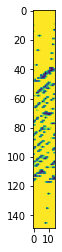

In [280]:
plt.imshow(np.asarray(letters))

In [233]:
print(img_reconstructed.shape)

(125, 206)


In [228]:
#[ultimaRepetida+1][leftMargin+1] , [shape_y-9][rightMargin-1]
'''
for i in range(ultimaRepetida+1, shape_y-9):
    for j in range(leftMargin+1, rightMargin-1):
        img_reconstructed[i][j] = letters[i-(ultimaRepetida+1)][j-(leftMargin+1)]
'''



'\nfor i in range(ultimaRepetida+1, shape_y-9):\n    for j in range(leftMargin+1, rightMargin-1):\n        img_reconstructed[i][j] = letters[i-(ultimaRepetida+1)][j-(leftMargin+1)]\n'

In [273]:
#[ultimaRepetida+1][leftMargin+1] , [shape_y-9][rightMargin-1]

print(letters.shape)


print((shape_y-9) - ultimaRepetida-1-1)
print((rightMargin-1)-leftMargin+1)



for idxi,i in enumerate(range(leftMargin-1, rightMargin-1-1-1)):
    for idxj,j in enumerate(range(ultimaRepetida-1, shape_y-9-1-1)):
        print(idxi, idxj)
        img_reconstructed[i][j] = letters[idxi][idxj]




(149, 15)
14
151
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
12 13
12 14
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
13 14
14 0
14 1
14 

IndexError: index 125 is out of bounds for axis 0 with size 125

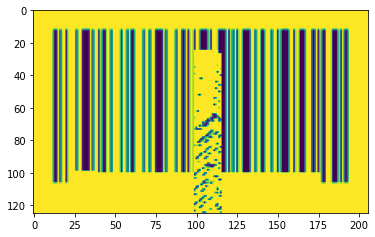

In [274]:
plt.imshow(np.asarray(img_reconstructed))

In [143]:
b = 255
c = b.to_bytes(2, byteorder="big", signed=False)

print(c)
print(int.from_bytes(c, byteorder="big", signed=False))
print("espai disponible:",954-348)
print("longitud wordBefore:", len(wordBefore))
long = 1370+348
print("longitd del bin",long)
print("bps codificats=", long*8/(shape_x*shape_y))

b'\x00\xff'
255
espai disponible: 606
longitud wordBefore: 2235
longitd del bin 1718
bps codificats= 0.533747572815534


In [144]:
mostres = (shape_x*shape_y)
print("numero de mostres:", mostres)
#motsres = samples * 1bps b/s-> bits
#mida bits/8 = bytes
print("Mida maximo amb 1bps", mostres/8 )

numero de mostres: 25750
Mida maximo amb 1bps 3218.75
